#### TCN Preprocessing
Demonstrates preprocessing of FVCOM data for Temporal Convolutional Network (TCN) training and inference.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from oadap.prediction.tcn.preprocessing import (
    calculate_climatology,
    calculate_climatology_days,
    group,
    svd_decompose,
    reconstruct_field,
    uniform_sampling,
    create_windows,
)

from oadap.utils import load_mat

%matplotlib inline

Configure Parameters

In [7]:
# Parameters
data_dir = "../../data/FVCOM/"
array_path = data_dir + "salinity/salinity.mat"
output_dir = data_dir + "preprocessed/salinity/all2/"

artifacts_only = True  # Save entire domain artifacts only
rewrite = True         # Rewrite existing output
window_size = 20       # Window size for windowing
stride = 1             # Stride for windowing
sampling_rate = 1      # Sampling rate for windowing
n_samples = 1200       # Number of uniformly distributed xy points to consider

Load Data

In [8]:
lon = load_mat(os.path.join(data_dir, "x.mat"))
lat = load_mat(os.path.join(data_dir, "y.mat"))
xy = np.column_stack((lon, lat))

h = load_mat(os.path.join(data_dir, "h.mat"))        # Distance from surface to ocean floor
siglay = load_mat(os.path.join(data_dir, "siglay.mat"))
time = pd.date_range(start="1/1/2005", end="12/31/2013")

neighbors = np.load(os.path.join(data_dir, "neighbor_inds.npy")).astype(np.int32)

nx = lon.shape[0]
nt = time.shape[0]
nz = siglay.shape[1]
n_neighbors = neighbors.shape[-1]

field = load_mat(array_path)
field = field.transpose((0, 2, 1))  # Shape: (nx, nt, nz)
assert field.shape == (nx, nt, nz)
surface = field[..., 0]  # Surface layer

Visualize the Spatial Distribution

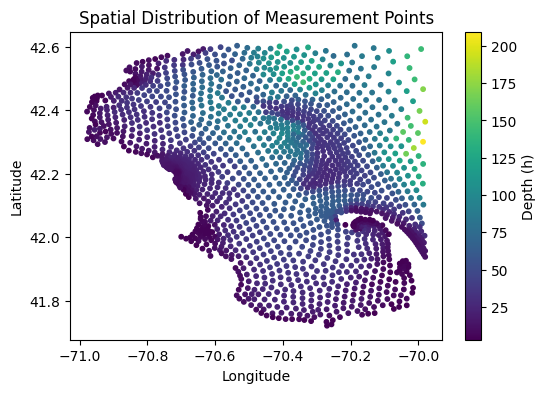

In [25]:
plt.figure(figsize=(6, 4))
plt.scatter(lon, lat, c=h.squeeze(), cmap='viridis', s=10)
plt.colorbar(label='Depth (h)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Measurement Points')
plt.show()

SVD Decomposition of Anomalies

In [12]:
climatology_days_3d = calculate_climatology_days(time=time, data=field)
climatology_3d, anomalies_3d = calculate_climatology(time=time, data=field)

q_anomaly, phi_anomaly, mu_anomaly, _ = svd_decompose(
    anomalies_3d, n_modes=2, check=False, align=True
)

Visualize Climatology and Anomalies

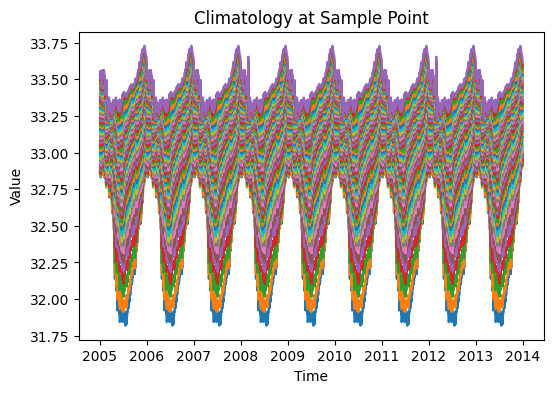

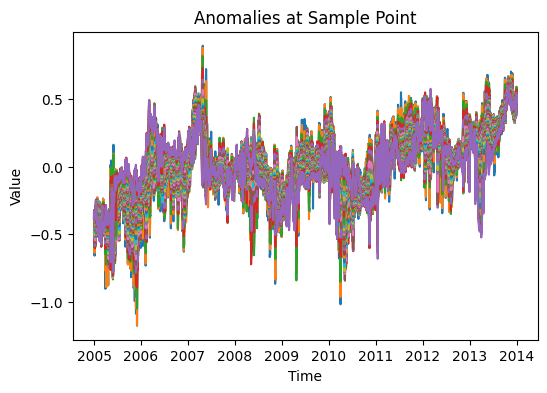

In [24]:
sample_point = 0  # Index of a sample point

# Plot climatology for the sample point
plt.figure(figsize=(6, 4))
plt.plot(time, climatology_3d[sample_point, :], label='Climatology')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Climatology at Sample Point')
plt.show()

# Plot anomalies for the sample point
plt.figure(figsize=(6, 4))
plt.plot(time, anomalies_3d[sample_point, :], label='Anomalies')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Anomalies at Sample Point')
plt.show()


Grouping with Neighbors

In [19]:
climatology_surface, anomalies_surface = calculate_climatology(
    time=time, data=surface[..., np.newaxis]
)
climatology_surface = climatology_surface.squeeze()
anomalies_surface = anomalies_surface.squeeze()

# Group points with their neighbors
anomalies_grouped = group(data=anomalies_surface, neighbor_inds=neighbors)
climatology_grouped = group(data=climatology_surface, neighbor_inds=neighbors)

Uniform Sampling

In [20]:
has_neighbors_mask = neighbors[:, 0] != -1
has_neighbor_inds = np.where(has_neighbors_mask)[0]

samples, sample_inds = uniform_sampling(
    xy[has_neighbors_mask], n_samples=n_samples, random_state=42
)
sample_mask = np.zeros(nx, dtype=bool)
sample_mask[has_neighbor_inds[sample_inds]] = True

Visualize sampled points

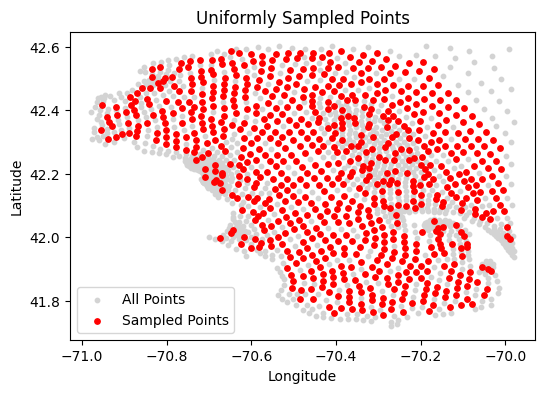

In [23]:
plt.figure(figsize=(6, 4))
plt.scatter(lon, lat, c='lightgrey', s=10, label='All Points')
plt.scatter(xy[sample_mask, 0], xy[sample_mask, 1], c='red', s=15, label='Sampled Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Uniformly Sampled Points')
plt.legend()
plt.show()

Build Inputs

In [26]:
X = np.stack(
    (
        anomalies_grouped[..., 0],
        anomalies_grouped[..., 1],
        anomalies_grouped[..., 2],
        anomalies_grouped[..., 3],
        anomalies_grouped[..., 4],
        climatology_surface,
        np.repeat(lon, nt).reshape(nx, nt),
        np.repeat(lat, nt).reshape(nx, nt),
        np.repeat(h, nt).reshape(nx, nt),
    ),
    axis=2,
)

n_days = nt
X_sample = X[sample_mask, -n_days:]
X_windowed_sample = create_windows(
    X_sample, window_size=window_size, sampling_rate=sampling_rate, stride=stride
)

Build Outputs

In [27]:
y_sample = np.dstack(
    (mu_anomaly[sample_mask, -n_days:], q_anomaly[sample_mask, -n_days:])
)
y_sample = create_windows(
    y_sample,
    window_size=window_size,
    sampling_rate=sampling_rate,
    stride=stride,
    last_only=True,
)

Reconstruct Field for Sampled Points

In [28]:
field_sample = reconstruct_field(
    phi_anomaly[sample_mask],
    q_anomaly[sample_mask, -n_days:],
    mu_anomaly[sample_mask, -n_days:],
)
field_sample = create_windows(
    field_sample,
    window_size=window_size,
    sampling_rate=sampling_rate,
    stride=stride,
    last_only=True,
)
phi_sample = phi_anomaly[sample_mask]
xy_sample = xy[sample_mask]

Visualize Reconstructed Field

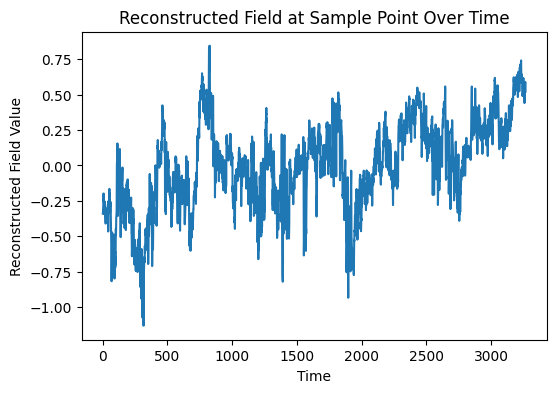

In [33]:
# Plot reconstructed field for a sample point over time
sample_index = 0  # Index within sampled points
plt.figure(figsize=(6, 4))
plt.plot(field_sample[sample_index, :, 0])
plt.xlabel('Time')
plt.ylabel('Reconstructed Field Value')
plt.title('Reconstructed Field at Sample Point Over Time')
plt.show()

Save Processed Data

In [ ]:
train_output_dir = os.path.join(output_dir, "train/")
artifacts_output_dir = os.path.join(output_dir, "artifacts/")

for path in [train_output_dir, artifacts_output_dir]:
    if not os.path.exists(path):
        os.makedirs(path)

# Save training data
np.save(os.path.join(train_output_dir, "X.npy"), X_windowed_sample)
np.save(os.path.join(train_output_dir, "y.npy"), y_sample)

# Save artifacts
np.save(os.path.join(artifacts_output_dir, "T.npy"), field_sample)
np.save(os.path.join(artifacts_output_dir, "phi.npy"), phi_sample)
np.save(os.path.join(artifacts_output_dir, "xy.npy"), xy_sample)
np.save(os.path.join(artifacts_output_dir, "climatology_days.npy"), climatology_days_3d[sample_mask])